In [129]:
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions
library(data.table)
library(dplyr)
library(mice)
library(randomForest)
library(arm)
library(pROC)
library(e1071)
library(caret)
library(tree)
library(gbm)
library(lightgbm)
## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files

# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

list.files(path = "../input")

## Saving data

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.

[1] "microsoft-malware-prediction" "sampled-train"

In [130]:
data_path = "../input/sampled-train/"
train = data.frame(fread(paste0(data_path, "train.csv"))) %>%
    mutate(HasDetections = factor(HasDetections))
train[train==""] <- NA

In [131]:
dim(train)

[1] 75000    45

In [132]:
colnames(train)

[1] "MachineIdentifier"                                
 [2] "ProductName"                                      
 [3] "EngineVersion"                                    
 [4] "AVProductsInstalled"                              
 [5] "AVProductsEnabled"                                
 [6] "HasTpm"                                           
 [7] "OrganizationIdentifier"                           
 [8] "Platform"                                         
 [9] "Processor"                                        
[10] "OsVer"                                            
[11] "OsBuild"                                          
[12] "OsSuite"                                          
[13] "OsBuildLab"                                       
[14] "SkuEdition"                                       
[15] "IsProtected"                                      
[16] "SMode"                                            
[17] "IeVerIdentifier"                                  
[18] "SmartScreen"                                      
[19] "Firewall"                                         
[20] "Census_MDC2FormFactor"                            
[21] "Census_ProcessorManufacturerIdentifier"           
[22] "Census_ProcessorModelIdentifier"                  
[23] "Census_PrimaryDiskTypeName"                       
[24] "Census_SystemVolumeTotalCapacity"                 
[25] "Census_HasOpticalDiskDrive"                       
[26] "Census_TotalPhysicalRAM"                          
[27] "Census_ChassisTypeName"                           
[28] "Census_InternalPrimaryDiagonalDisplaySizeInInches"
[29] "Census_PowerPlatformRoleName"                     
[30] "Census_InternalBatteryType"                       
[31] "Census_InternalBatteryNumberOfCharges"            
[32] "Census_OSArchitecture"                            
[33] "Census_OSEdition"                                 
[34] "Census_OSSkuName"                                 
[35] "Census_OSInstallTypeName"                         
[36] "Census_OSUILocaleIdentifier"                      
[37] "Census_OSWUAutoUpdateOptionsName"                 
[38] "Census_GenuineStateName"                          
[39] "Census_FlightRing"                                
[40] "Census_IsSecureBootEnabled"                       
[41] "Census_IsTouchEnabled"                            
[42] "Census_IsPenCapable"                              
[43] "Census_IsAlwaysOnAlwaysConnectedCapable"          
[44] "Wdft_IsGamer"                                     
[45] "HasDetections"

In [133]:
boolnames<- names(train)[grepl( "Is|Has" , names(train))]
boolnames<-c(boolnames,c("SMode","Firewall"))
boolnames

[1] "HasTpm"                                 
 [2] "IsProtected"                            
 [3] "Census_HasOpticalDiskDrive"             
 [4] "Census_IsSecureBootEnabled"             
 [5] "Census_IsTouchEnabled"                  
 [6] "Census_IsPenCapable"                    
 [7] "Census_IsAlwaysOnAlwaysConnectedCapable"
 [8] "Wdft_IsGamer"                           
 [9] "HasDetections"                          
[10] "SMode"                                  
[11] "Firewall"

In [134]:
ordinal_cols = c("AVProductsInstalled", "AVProductsEnabled")

In [135]:
numeric_cols = c( "Census_SystemVolumeTotalCapacity", "Census_TotalPhysicalRAM"
                 , "Census_InternalPrimaryDiagonalDisplaySizeInInches"
                 , "Census_InternalBatteryNumberOfCharges")

In [136]:
idnames<- names(train)[grepl( "Identifier" , names(train))]
idnames

[1] "MachineIdentifier"                     
[2] "OrganizationIdentifier"                
[3] "IeVerIdentifier"                       
[4] "Census_ProcessorManufacturerIdentifier"
[5] "Census_ProcessorModelIdentifier"       
[6] "Census_OSUILocaleIdentifier"

In [137]:
character_cols = train %>%
    select_if(function(x) !is.numeric(x)) %>%
    colnames() 
character_cols<-c(character_cols,c("OsSuite","OsBuild"))
character_cols <- character_cols[character_cols!=c("MachineIdentifier","HasDetections")]          
character_cols

[1] "ProductName"                      "EngineVersion"                   
 [3] "Platform"                         "Processor"                       
 [5] "OsVer"                            "OsBuildLab"                      
 [7] "SkuEdition"                       "SmartScreen"                     
 [9] "Census_MDC2FormFactor"            "Census_PrimaryDiskTypeName"      
[11] "Census_ChassisTypeName"           "Census_PowerPlatformRoleName"    
[13] "Census_InternalBatteryType"       "Census_OSArchitecture"           
[15] "Census_OSEdition"                 "Census_OSSkuName"                
[17] "Census_OSInstallTypeName"         "Census_OSWUAutoUpdateOptionsName"
[19] "Census_GenuineStateName"          "Census_FlightRing"               
[21] "OsSuite"                          "OsBuild"

In [138]:
factor_vars<-c(character_cols,ordinal_cols,boolnames,idnames)
factor_vars

train[factor_vars] <- lapply(train[factor_vars], as.factor)

[1] "ProductName"                            
 [2] "EngineVersion"                          
 [3] "Platform"                               
 [4] "Processor"                              
 [5] "OsVer"                                  
 [6] "OsBuildLab"                             
 [7] "SkuEdition"                             
 [8] "SmartScreen"                            
 [9] "Census_MDC2FormFactor"                  
[10] "Census_PrimaryDiskTypeName"             
[11] "Census_ChassisTypeName"                 
[12] "Census_PowerPlatformRoleName"           
[13] "Census_InternalBatteryType"             
[14] "Census_OSArchitecture"                  
[15] "Census_OSEdition"                       
[16] "Census_OSSkuName"                       
[17] "Census_OSInstallTypeName"               
[18] "Census_OSWUAutoUpdateOptionsName"       
[19] "Census_GenuineStateName"                
[20] "Census_FlightRing"                      
[21] "OsSuite"                                
[22] "OsBuild"                                
[23] "AVProductsInstalled"                    
[24] "AVProductsEnabled"                      
[25] "HasTpm"                                 
[26] "IsProtected"                            
[27] "Census_HasOpticalDiskDrive"             
[28] "Census_IsSecureBootEnabled"             
[29] "Census_IsTouchEnabled"                  
[30] "Census_IsPenCapable"                    
[31] "Census_IsAlwaysOnAlwaysConnectedCapable"
[32] "Wdft_IsGamer"                           
[33] "HasDetections"                          
[34] "SMode"                                  
[35] "Firewall"                               
[36] "MachineIdentifier"                      
[37] "OrganizationIdentifier"                 
[38] "IeVerIdentifier"                        
[39] "Census_ProcessorManufacturerIdentifier" 
[40] "Census_ProcessorModelIdentifier"        
[41] "Census_OSUILocaleIdentifier"

In [139]:
str(train)

'data.frame':	75000 obs. of  45 variables:
 $ MachineIdentifier                                : Factor w/ 75000 levels "0000ba435580256a4a2c9e3b53fcb39a",..: 62073 22894 48192 49461 62159 33160 3124 70392 34809 25086 ...
 $ ProductName                                      : Factor w/ 2 levels "mse","win8defender": 2 2 2 2 2 2 2 2 2 2 ...
 $ EngineVersion                                    : Factor w/ 41 levels "1.1.11701.0",..: 39 9 39 38 39 39 35 38 39 14 ...
 $ AVProductsInstalled                              : Factor w/ 6 levels "1","2","3","4",..: 1 3 1 1 1 1 1 2 1 2 ...
 $ AVProductsEnabled                                : Factor w/ 5 levels "0","1","2","3",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ HasTpm                                           : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ OrganizationIdentifier                           : Factor w/ 37 levels "1","2","3","4",..: NA 19 NA 19 19 13 19 NA 19 NA ...
 $ Platform                                         : Factor w/ 4 

In [140]:
cols.keep <- c("Census_PrimaryDiskTotalCapacity",
               "Census_SystemVolumeTotalCapacity",
               "MachineIdentifier",
               "HasDetections")
for(colName in colnames(train[, factor_vars])) {
  if(!(colName %in% cols.keep)) {
    train[[colName]] <- factor(ifelse(!is.na(train[[colName]]),
                                         as.factor(train[[colName]]),
                                         "Missing"))
  }
}

In [141]:
str(train)

'data.frame':	75000 obs. of  45 variables:
 $ MachineIdentifier                                : Factor w/ 75000 levels "0000ba435580256a4a2c9e3b53fcb39a",..: 62073 22894 48192 49461 62159 33160 3124 70392 34809 25086 ...
 $ ProductName                                      : Factor w/ 2 levels "1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ EngineVersion                                    : Factor w/ 41 levels "1","2","3","4",..: 39 9 39 38 39 39 35 38 39 14 ...
 $ AVProductsInstalled                              : Factor w/ 7 levels "1","2","3","4",..: 1 3 1 1 1 1 1 2 1 2 ...
 $ AVProductsEnabled                                : Factor w/ 6 levels "1","2","3","4",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ HasTpm                                           : Factor w/ 2 levels "1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ OrganizationIdentifier                           : Factor w/ 38 levels "1","10","11",..: 38 11 38 11 11 5 11 38 11 38 ...
 $ Platform                                         : Factor w/ 4 levels "1","2"

In [142]:
cbind(sort(colSums(is.na(train))/nrow(train),decreasing=TRUE))

Census_InternalBatteryNumberOfCharges,0.596986667
Census_TotalPhysicalRAM,0.009346667
Census_SystemVolumeTotalCapacity,0.006533333
Census_InternalPrimaryDiagonalDisplaySizeInInches,0.005413333
MachineIdentifier,0.000000000
ProductName,0.000000000
EngineVersion,0.000000000
AVProductsInstalled,0.000000000
AVProductsEnabled,0.000000000
HasTpm,0.000000000
OrganizationIdentifier,0.000000000


In [143]:
#train <- mice(train,m=10,defaultMethod=c("pmm"),print=F)
train$Census_InternalBatteryNumberOfCharges<- ifelse(is.na(train$Census_InternalBatteryNumberOfCharges),mean(train$Census_InternalBatteryNumberOfCharges,na.rm=TRUE),train$Census_InternalBatteryNumberOfCharges)
train$Census_TotalPhysicalRAM<- ifelse(is.na(train$Census_TotalPhysicalRAM),mean(train$Census_TotalPhysicalRAM,na.rm=TRUE),train$Census_TotalPhysicalRAM)
train$Census_SystemVolumeTotalCapacity<- ifelse(is.na(train$Census_SystemVolumeTotalCapacity),mean(train$Census_SystemVolumeTotalCapacity,na.rm=TRUE),train$Census_SystemVolumeTotalCapacity)
train$Census_InternalPrimaryDiagonalDisplaySizeInInches<- ifelse(is.na(train$Census_InternalPrimaryDiagonalDisplaySizeInInches),mean(train$Census_InternalPrimaryDiagonalDisplaySizeInInches,na.rm=TRUE),train$Census_InternalPrimaryDiagonalDisplaySizeInInches)
cbind(sort(colSums(is.na(train))/nrow(train),decreasing=TRUE))

MachineIdentifier,0
ProductName,0
EngineVersion,0
AVProductsInstalled,0
AVProductsEnabled,0
HasTpm,0
OrganizationIdentifier,0
Platform,0
Processor,0
OsVer,0
OsBuild,0


In [144]:
str(train)

'data.frame':	75000 obs. of  45 variables:
 $ MachineIdentifier                                : Factor w/ 75000 levels "0000ba435580256a4a2c9e3b53fcb39a",..: 62073 22894 48192 49461 62159 33160 3124 70392 34809 25086 ...
 $ ProductName                                      : Factor w/ 2 levels "1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ EngineVersion                                    : Factor w/ 41 levels "1","2","3","4",..: 39 9 39 38 39 39 35 38 39 14 ...
 $ AVProductsInstalled                              : Factor w/ 7 levels "1","2","3","4",..: 1 3 1 1 1 1 1 2 1 2 ...
 $ AVProductsEnabled                                : Factor w/ 6 levels "1","2","3","4",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ HasTpm                                           : Factor w/ 2 levels "1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ OrganizationIdentifier                           : Factor w/ 38 levels "1","10","11",..: 38 11 38 11 11 5 11 38 11 38 ...
 $ Platform                                         : Factor w/ 4 levels "1","2"

In [145]:
train_input=train[,!(names(train) %in% c("MachineIdentifier","Census_ProcessorModelIdentifier","OsBuildLab","Census_OSUILocaleIdentifier","Census_InternalBatteryType","Census_ChassisTypeName","Census_OSEdition","IeVerIdentifier","OsBuild","EngineVersion","OrganizationIdentifier","Census_MDC2FormFactor","SmartScreen","Census_OSSkuName"))]
str(train_input)

'data.frame':	75000 obs. of  31 variables:
 $ ProductName                                      : Factor w/ 2 levels "1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ AVProductsInstalled                              : Factor w/ 7 levels "1","2","3","4",..: 1 3 1 1 1 1 1 2 1 2 ...
 $ AVProductsEnabled                                : Factor w/ 6 levels "1","2","3","4",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ HasTpm                                           : Factor w/ 2 levels "1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ Platform                                         : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ Processor                                        : Factor w/ 3 levels "1","2","3": 3 2 2 2 2 2 2 2 2 2 ...
 $ OsVer                                            : Factor w/ 9 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ OsSuite                                          : Factor w/ 6 levels "1","2","3","4",..: 6 6 6 2 2 2 6 6 2 6 ...
 $ SkuEdition                                       :

In [146]:
mod4<- randomForest(HasDetections ~ ., data =train_input , importance =TRUE,ntree=800)


In [147]:
mod4


Call:
 randomForest(formula = HasDetections ~ ., data = train_input,      importance = TRUE, ntree = 800) 
               Type of random forest: classification
                     Number of trees: 800
No. of variables tried at each split: 5

        OOB estimate of  error rate: 40.66%
Confusion matrix:
      0     1 class.error
0 22364 15101   0.4030695
1 15393 22142   0.4100972

In [148]:
## Confusion matrix
Conf_mat_rf <- confusionMatrix(predict(mod4,type="response"),
                                 as.factor(train$HasDetections),positive = "1")
Conf_mat_rf$table #compare to Conf_mat$table
Conf_mat_rf$overall["Accuracy"]
#still worse
Conf_mat_rf$byClass[c("Sensitivity","Specificity")]

          Reference
Prediction     0     1
         0 22364 15393
         1 15101 22142

Accuracy 
0.5934133

Sensitivity Specificity 
  0.5899028   0.5969305

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = train$HasDetections, predictor = predict(mod4,     type = "prob")[, 2], plot = T, print.thres = "best", legacy.axes = T,     print.auc = T, col = "red3")

Data: predict(mod4, type = "prob")[, 2] in 37465 controls (train$HasDetections 0) < 37535 cases (train$HasDetections 1).
Area under the curve: 0.6254

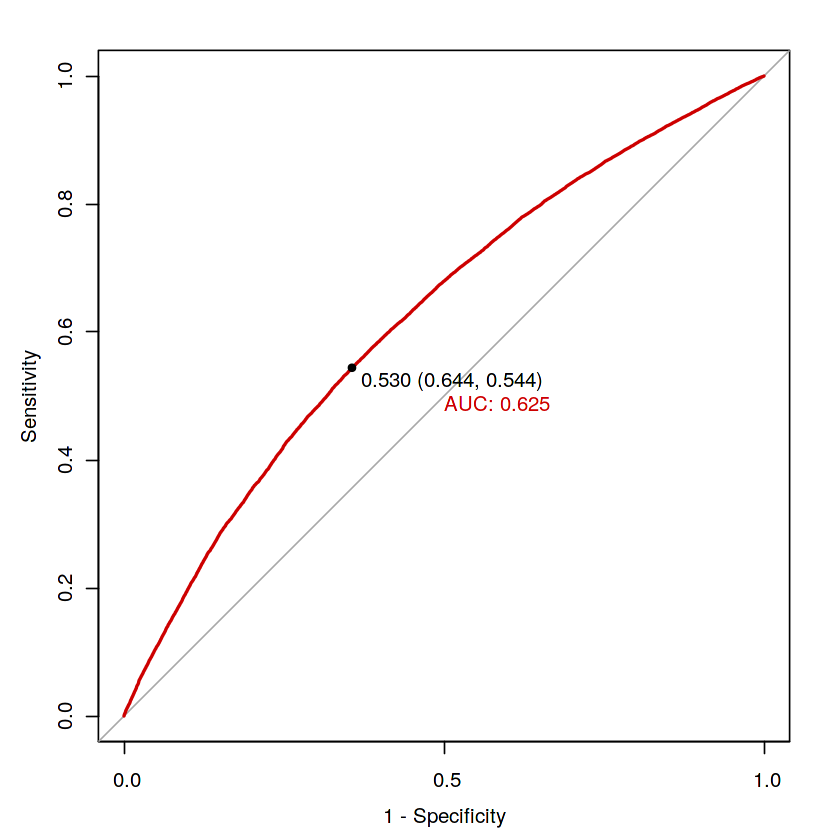

In [149]:
## ROC curve
roc(train$HasDetections,predict(mod4,type="prob")[,2],plot=T,print.thres="best",legacy.axes=T,print.auc =T,col="red3")

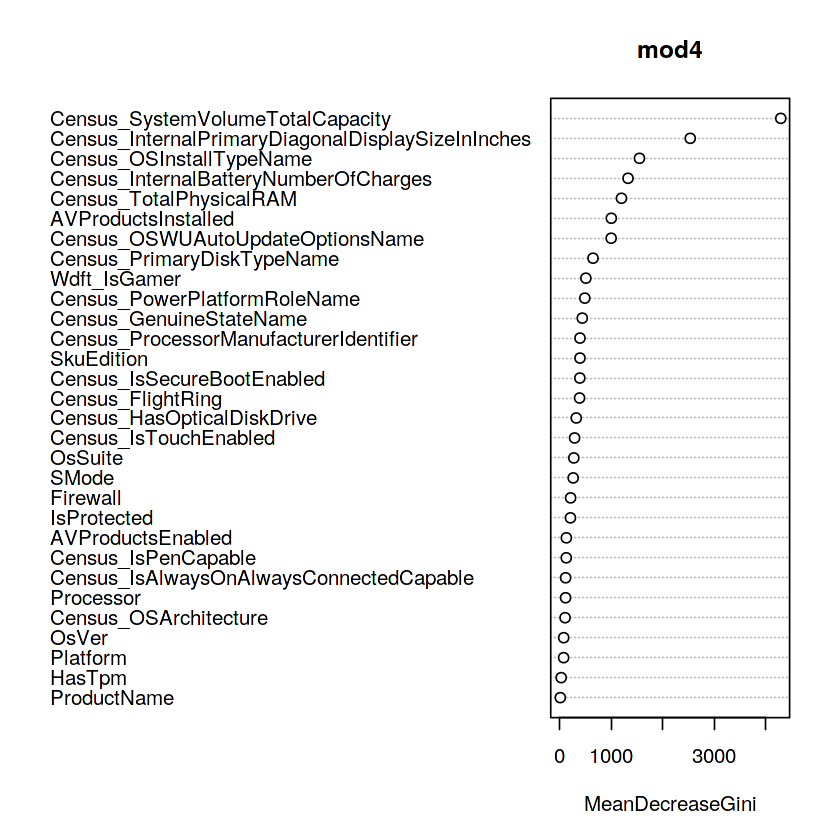

In [150]:
varImpPlot(mod4,type=2)

In [151]:
mod4$importance

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
ProductName,5.768543e-05,2.601148e-05,4.181136e-05,14.03832
AVProductsInstalled,3.862742e-02,1.445475e-02,2.653128e-02,1003.41808
AVProductsEnabled,-8.867068e-04,1.610347e-03,3.620957e-04,131.48713
HasTpm,-1.395069e-04,3.956317e-04,1.281878e-04,31.38701
Platform,-4.426980e-04,1.204453e-03,3.815616e-04,78.50992
Processor,-1.424005e-03,6.853683e-03,2.717992e-03,116.32563
OsVer,-5.577257e-04,1.374248e-03,4.088512e-04,79.74634
OsSuite,-8.803790e-04,4.923118e-03,2.023473e-03,275.98113
SkuEdition,-1.338840e-03,5.957398e-03,2.313043e-03,395.65008
IsProtected,1.935279e-03,2.378029e-03,2.156912e-03,210.91207


In [152]:
chisq.test(table(train[,c("IsProtected","HasDetections")]))


	Pearson's Chi-squared test

data:  table(train[, c("IsProtected", "HasDetections")])
X-squared = 251.73, df = 2, p-value < 2.2e-16


In [153]:
chisq.test(table(train[,c("Census_IsTouchEnabled","HasDetections")]))


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(train[, c("Census_IsTouchEnabled", "HasDetections")])
X-squared = 173.75, df = 1, p-value < 2.2e-16


In [154]:
chisq.test(table(train[,c("Census_IsPenCapable","HasDetections")]))


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(train[, c("Census_IsPenCapable", "HasDetections")])
X-squared = 29.271, df = 1, p-value = 6.295e-08


In [155]:
chisq.test(table(train[,c("Platform","HasDetections")]))


	Pearson's Chi-squared test

data:  table(train[, c("Platform", "HasDetections")])
X-squared = 16.985, df = 3, p-value = 0.0007117


In [156]:
chisq.test(table(train[,c("HasTpm","HasDetections")]))


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(train[, c("HasTpm", "HasDetections")])
X-squared = 1.9056, df = 1, p-value = 0.1675


In [157]:
chisq.test(table(train[,c("Census_IsSecureBootEnabled","HasDetections")]))


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(train[, c("Census_IsSecureBootEnabled", "HasDetections")])
X-squared = 0.099298, df = 1, p-value = 0.7527


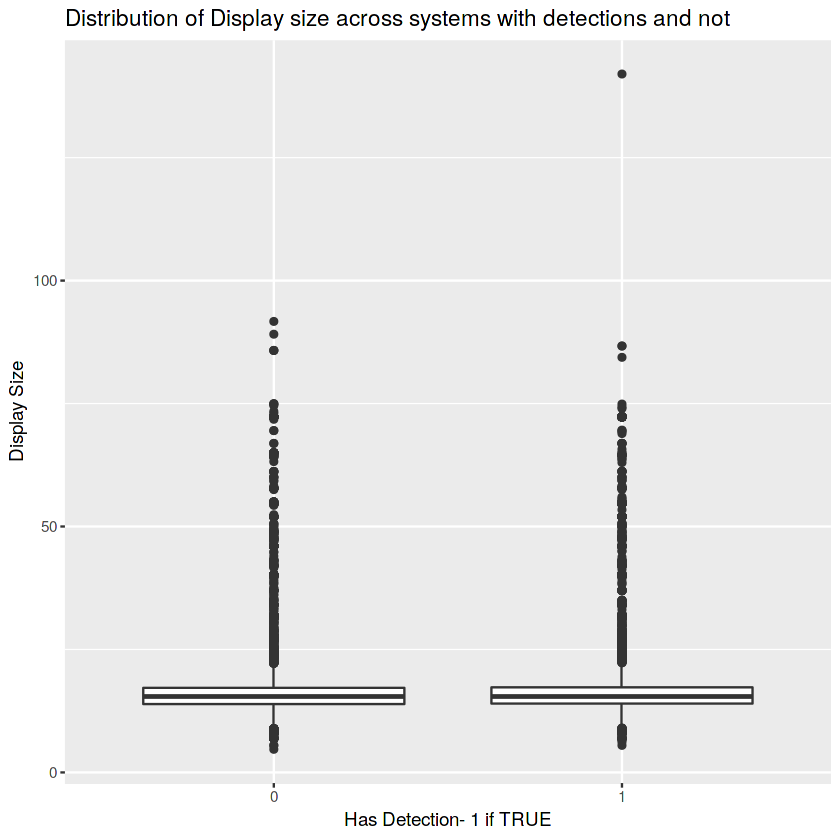

In [158]:
train %>%
  ggplot(aes(x = as.factor(HasDetections), y = Census_InternalPrimaryDiagonalDisplaySizeInInches)) +
  geom_boxplot() +
  xlab("Has Detection- 1 if TRUE") +
  ylab("Display Size") +
  ggtitle("Distribution of Display size across systems with detections and not")

In [159]:
table(train_input$HasDetections)


    0     1 
37465 37535 


Classification tree:
tree(formula = HasDetections ~ ., data = train_input)
Variables actually used in tree construction:
[1] "AVProductsInstalled"
Number of terminal nodes:  2 
Residual mean deviance:  1.364 = 102300 / 75000 
Misclassification error rate: 0.4315 = 32363 / 75000 

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

1) root 75000 104000 1 ( 0.4995 0.5005 )  
  2) AVProductsInstalled: 2,3,4,5,Missing 22710  30330 0 ( 0.6123 0.3877 ) *
  3) AVProductsInstalled: 1,6 52290  71980 1 ( 0.4505 0.5495 ) *

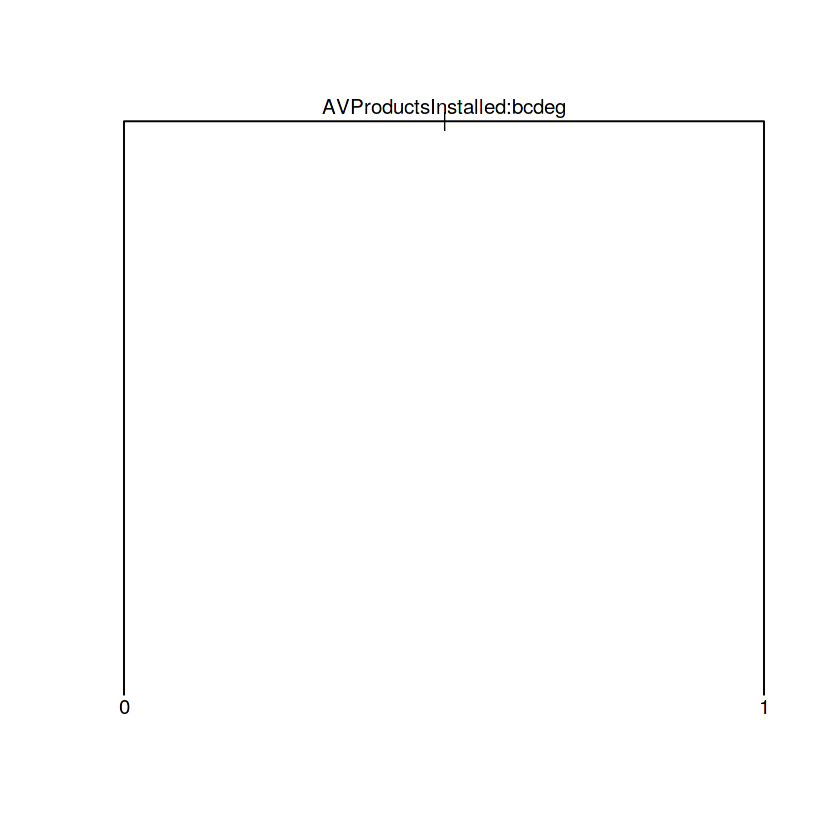

In [160]:
###### CART

mod5 <- tree(HasDetections ~ ., data = train_input)
summary(mod5)
plot(mod5)
text(mod5)
mod5

[1] 1 0 1 1 1 1
Levels: 0 1

          Reference
Prediction     0     1
         0 13906  8804
         1 23559 28731

Accuracy 
0.5684933

Sensitivity Specificity 
  0.7654456   0.3711731

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = train_input$HasDetections, predictor = predict(mod5,     type = "vector")[, 2], plot = T, print.thres = "best", legacy.axes = T,     print.auc = T, col = "red3")

Data: predict(mod5, type = "vector")[, 2] in 37465 controls (train_input$HasDetections 0) < 37535 cases (train_input$HasDetections 1).
Area under the curve: 0.5683

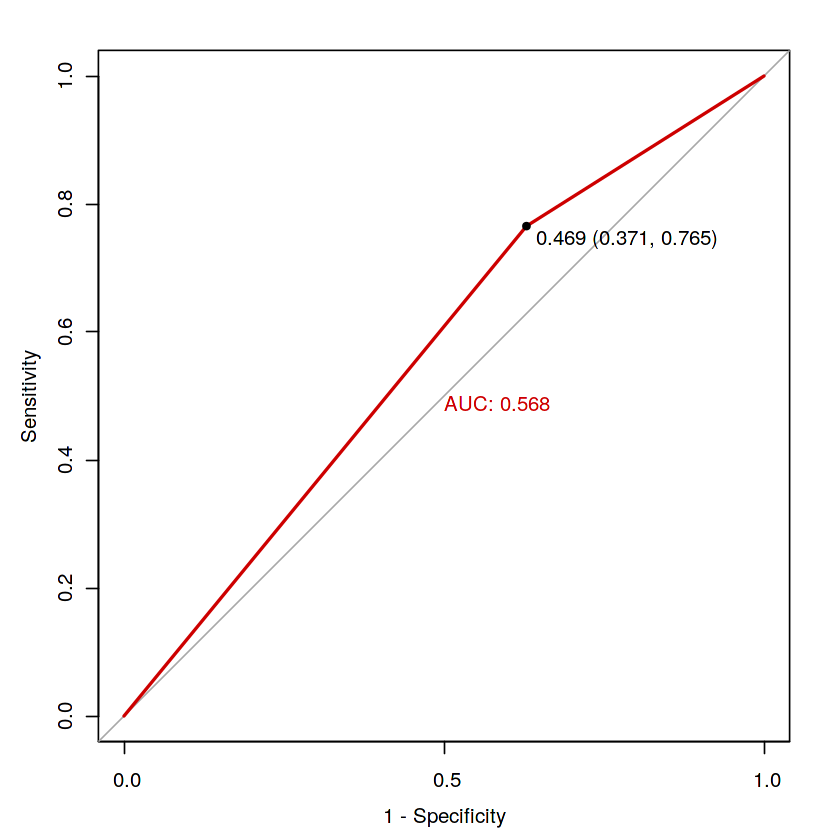

In [161]:
head(predict(mod5,type="class"))

## Confusion matrix
Conf_mat_cart <- confusionMatrix(predict(mod5,type="class"),
                            as.factor(train$HasDetections),positive = "1")
Conf_mat_cart$table #compare to Conf_mat$table
Conf_mat_cart$overall["Accuracy"] #compare to Conf_mat$overall["Accuracy"]
#lower accuracy than the logistic model
Conf_mat_cart$byClass[c("Sensitivity","Specificity")] #compare to Conf_mat$byClass[c("Sensitivity","Specificity")]
#higher specificity but lower sensitivity

## ROC curve
roc(train_input$HasDetections,predict(mod5,type="vector")[,2],plot=T,print.thres="best",legacy.axes=T,print.auc =T,col="red3")

In [162]:
mod6  <- randomForest(HasDetections ~ ., data = train_input,mtry=4)
mod6


Call:
 randomForest(formula = HasDetections ~ ., data = train_input,      mtry = 4) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 40.43%
Confusion matrix:
      0     1 class.error
0 21946 15519   0.4142266
1 14802 22733   0.3943519

          Reference
Prediction     0     1
         0 21946 14802
         1 15519 22733

Accuracy 
 0.59572

Sensitivity Specificity 
  0.6056481   0.5857734

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = train_input$HasDetections, predictor = predict(mod6,     type = "prob")[, 2], plot = T, print.thres = "best", legacy.axes = T,     print.auc = T, col = "red3")

Data: predict(mod6, type = "prob")[, 2] in 37465 controls (train_input$HasDetections 0) < 37535 cases (train_input$HasDetections 1).
Area under the curve: 0.6277

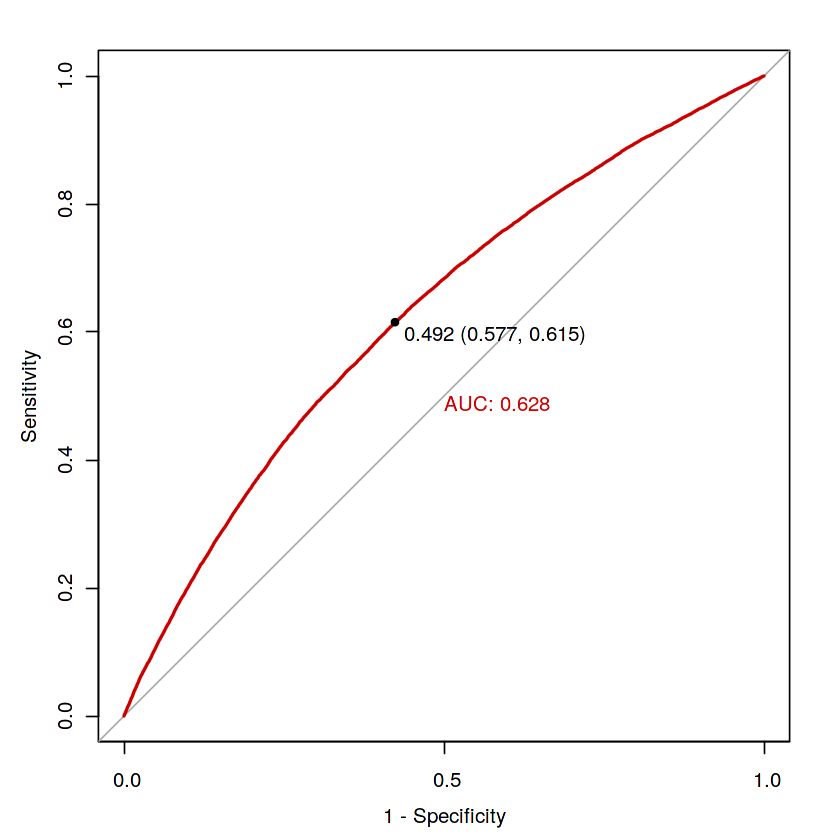

In [163]:
## Confusion matrix
Conf_mat_bagg <- confusionMatrix(predict(mod6,type="response"),
                                 as.factor(train_input$HasDetections),positive = "1")
Conf_mat_bagg$table #compare to Conf_mat$table
Conf_mat_bagg$overall["Accuracy"]
#much worse
Conf_mat_bagg$byClass[c("Sensitivity","Specificity")]

## ROC curve
roc(train_input$HasDetections,predict(mod6,type="prob")[,2],plot=T,print.thres="best",legacy.axes=T,print.auc =T,col="red3")
#also worse than logistic regression and cart

In [164]:
str(train_input)

'data.frame':	75000 obs. of  31 variables:
 $ ProductName                                      : Factor w/ 2 levels "1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ AVProductsInstalled                              : Factor w/ 7 levels "1","2","3","4",..: 1 3 1 1 1 1 1 2 1 2 ...
 $ AVProductsEnabled                                : Factor w/ 6 levels "1","2","3","4",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ HasTpm                                           : Factor w/ 2 levels "1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ Platform                                         : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ Processor                                        : Factor w/ 3 levels "1","2","3": 3 2 2 2 2 2 2 2 2 2 ...
 $ OsVer                                            : Factor w/ 9 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ OsSuite                                          : Factor w/ 6 levels "1","2","3","4",..: 6 6 6 2 2 2 6 6 2 6 ...
 $ SkuEdition                                       :

In [165]:
mod7 <- glm(HasDetections ~
                ProductName+
                HasTpm+
                AVProductsEnabled+
                Census_TotalPhysicalRAM+
                Census_HasOpticalDiskDrive+
                Firewall +
                Census_InternalPrimaryDiagonalDisplaySizeInInches+
                Census_IsTouchEnabled+
                Census_IsPenCapable+
                Census_IsAlwaysOnAlwaysConnectedCapable+
                Census_IsSecureBootEnabled +
                Wdft_IsGamer+
                Census_TotalPhysicalRAM:Census_IsTouchEnabled+
                Census_TotalPhysicalRAM:Wdft_IsGamer+
                Census_HasOpticalDiskDrive:Wdft_IsGamer,
             data = train_input,
             family = "binomial")

summary(mod7)


Call:
glm(formula = HasDetections ~ ProductName + HasTpm + AVProductsEnabled + 
    Census_TotalPhysicalRAM + Census_HasOpticalDiskDrive + Firewall + 
    Census_InternalPrimaryDiagonalDisplaySizeInInches + Census_IsTouchEnabled + 
    Census_IsPenCapable + Census_IsAlwaysOnAlwaysConnectedCapable + 
    Census_IsSecureBootEnabled + Wdft_IsGamer + Census_TotalPhysicalRAM:Census_IsTouchEnabled + 
    Census_TotalPhysicalRAM:Wdft_IsGamer + Census_HasOpticalDiskDrive:Wdft_IsGamer, 
    family = "binomial", data = train_input)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9788  -1.1723   0.8002   1.1743   1.8099  

Coefficients:
                                                    Estimate Std. Error z value
(Intercept)                                       -8.330e-01  2.180e-01  -3.821
ProductName2                                      -4.443e-01  2.529e-01  -1.757
HasTpm2                                            5.953e-01  2.095e-01   2.842
AVProductsEnabled2    

In [ ]:
## Confusion matrix
Conf_mat <- confusionMatrix(as.factor(ifelse(fitted(mod7) >= 0.5, "1","0")),
                            as.factor(train_input$HasDetections),positive = "1")
Conf_mat$table
Conf_mat$overall["Accuracy"]
Conf_mat$byClass[c("Sensitivity","Specificity")] #True positive rate and True negative rate

## ROC curve
roc(train_input$HasDetections,fitted(mod7),plot=T,print.thres="best",legacy.axes=T,print.auc =T,col="red3")

In [ ]:
plot(mod7)

In [ ]:
saveRDS(mod7,"mod7.RDS")